In [4]:
#Importacion de librerias para el analisis de informacion de clientes de Premium Choice 
import pandas as pd
import os



In [5]:
from pathlib import Path
import pandas as pd

# Ruta base
ruta_base = Path("../data/raw")  # 👈 Esta es la ubicación real


# Archivos relevantes (puedes ajustar si deseas incluir otros años)
archivos_ventas = sorted([
    archivo for archivo in ruta_base.glob("ventas_dcto_items_202*.xlsx")
])

# Consolidar ventas
ventas = pd.concat(
    [pd.read_excel(f, engine="openpyxl") for f in archivos_ventas],
    ignore_index=True
)

# Revisar columnas clave
ventas = ventas[['cod_cliente', 'cliente', 'defecha', 'cantidad', 'subtotal']]
ventas['defecha'] = pd.to_datetime(ventas['defecha'], errors='coerce')
ventas = ventas.dropna(subset=['defecha'])
ventas['mes'] = ventas['defecha'].dt.to_period('M')




In [6]:
#Calculo del comportamiento mensua del cliente
# Agregación mensual por cliente
cliente_mensual = ventas.groupby(['cod_cliente', 'mes']).agg({
    'cantidad': 'sum',
    'subtotal': 'sum'
}).reset_index()

# Métricas consolidadas por cliente
resumen = cliente_mensual.groupby('cod_cliente').agg({
    'mes': 'nunique',  # Cuántos meses distintos ha comprado
    'cantidad': 'mean',
    'subtotal': 'mean'
}).reset_index()

resumen.columns = ['cod_cliente', 'meses_con_compra', 'prom_cantidad_mensual', 'prom_gasto_mensual']


In [7]:
#Añadir el nombre del cliente y clasificar B2B probable
# Nombre de cliente desde ventas
nombres = ventas[['cod_cliente', 'cliente']].drop_duplicates()
resumen = resumen.merge(nombres, on='cod_cliente', how='left')

# Heurística textual (empresas típicas B2B)
resumen['es_nombre_empresa'] = resumen['cliente'].str.contains(
    r'\b(S[\s\.]?A[\s\.]?S|SAS|S\.A\.S\.?|LTDA|LIMITADA|S\.A|SA|SOCIEDAD\s+ANONIMA|EMPRESA|DISTRIBUIDORA|INDUSTRIA|CORP|COMPAÑ[ÍI]A|IMPORTADORA|EXPORTADORA)\b',
    case=False,
    na=False
)

# Clasificación B2B tentativa
resumen['es_b2b_probable'] = (
    (resumen['meses_con_compra'] > 8) |
    (resumen['prom_cantidad_mensual'] > 300) |
    (resumen['prom_gasto_mensual'] > 2_000_000) |
    (resumen['es_nombre_empresa'])
)


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_7000/191825516.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  resumen['es_nombre_empresa'] = resumen['cliente'].str.contains(


In [8]:
resumen['es_nombre_empresa'] = resumen['cliente'].str.contains(
    r'\b(S\.?A\.?S?\.?|LTDA|EMPRESA|DISTRIBUIDORA?|IMPORTADORA?|INDUSTRIA)\b',
    case=False, na=False
)



/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_7000/3349300399.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  resumen['es_nombre_empresa'] = resumen['cliente'].str.contains(


In [9]:
#Exploracion de la distribucion de los patrones nulos 
# Revisión rápida de estadísticas
resumen['prom_gasto_mensual'].describe()


count    6.890000e+02
mean     2.811886e+06
std      1.447654e+07
min     -4.313441e+06
25%      1.928752e+05
50%      6.294797e+05
75%      1.445573e+06
max      2.300000e+08
Name: prom_gasto_mensual, dtype: float64

In [10]:
#Revision de datos nulos o extremadamente grandes
# ¿Hay nulos o negativos?
print("Nulos:", resumen['prom_gasto_mensual'].isnull().sum())
print("Negativos:", (resumen['prom_gasto_mensual'] < 0).sum())


Nulos: 0
Negativos: 70


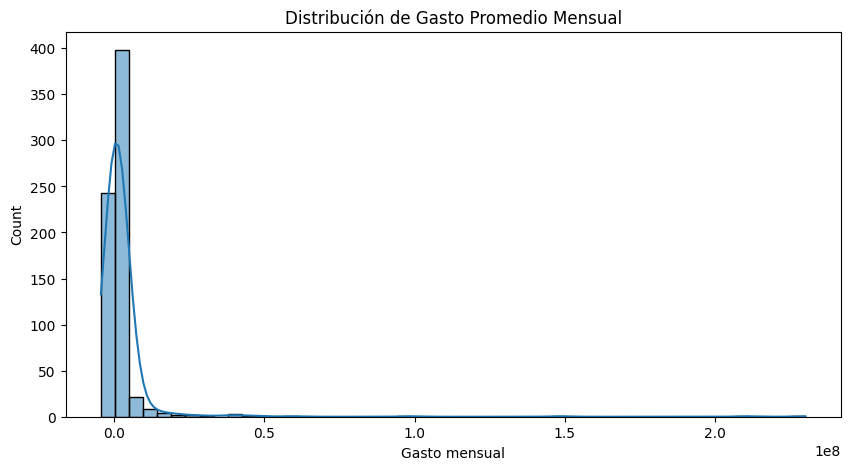

In [11]:
#Visualizacion de la distribución de los datos
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(resumen['prom_gasto_mensual'], bins=50, kde=True)
plt.title("Distribución de Gasto Promedio Mensual")
plt.xlabel("Gasto mensual")
plt.show()


             count          mean           std           min           25%  \
nivel_gasto                                                                  
alto          11.0  2.714800e+07  8.472423e+06  1.870003e+07  1.958265e+07   
bajo         563.0  9.486066e+05  9.340533e+05  0.000000e+00  2.808209e+05   
medio         38.0  7.828720e+06  3.213324e+06  4.512761e+06  5.360817e+06   

                      50%           75%           max  
nivel_gasto                                            
alto         2.469084e+07  3.412859e+07  3.976600e+07  
bajo         6.453733e+05  1.254801e+06  4.340080e+06  
medio        6.668747e+06  9.605286e+06  1.519099e+07  


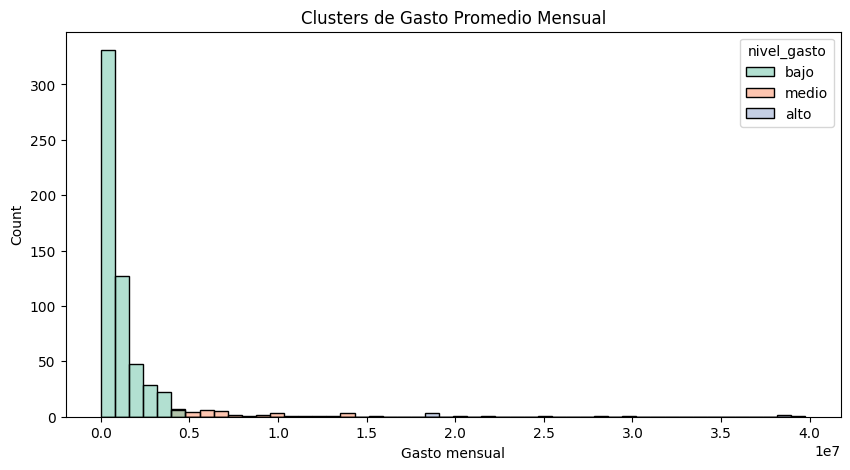

In [12]:
from sklearn.cluster import KMeans
import numpy as np

# Paso 1: limpiar negativos
resumen_filtrado = resumen[resumen['prom_gasto_mensual'] >= 0].copy()

# Paso 2: opcional - limitar el percentil 99 para evitar distorsión de outliers
p99 = resumen_filtrado['prom_gasto_mensual'].quantile(0.99)
resumen_filtrado = resumen_filtrado[resumen_filtrado['prom_gasto_mensual'] <= p99]

# Paso 3: aplicar KMeans con 3 clusters
X = resumen_filtrado[['prom_gasto_mensual']]
kmeans = KMeans(n_clusters=3, random_state=42)
resumen_filtrado['cluster'] = kmeans.fit_predict(X)

# Paso 4: analizar los clusters
centroides = kmeans.cluster_centers_.flatten()
cluster_ordenado = np.argsort(centroides)  # de menor a mayor

# Asignamos nombres a los clusters según gasto
cluster_map = {cluster_ordenado[0]: 'bajo', cluster_ordenado[1]: 'medio', cluster_ordenado[2]: 'alto'}
resumen_filtrado['nivel_gasto'] = resumen_filtrado['cluster'].map(cluster_map)

# Visualizar resumen de cada grupo
print(resumen_filtrado.groupby('nivel_gasto')['prom_gasto_mensual'].describe())

# Visualizar en gráfico
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(data=resumen_filtrado, x='prom_gasto_mensual', hue='nivel_gasto', bins=50, palette='Set2')
plt.title("Clusters de Gasto Promedio Mensual")
plt.xlabel("Gasto mensual")
plt.show()


In [14]:
# Crear carpeta outputs si no existe
import os
os.makedirs("outputs", exist_ok=True)

# Mostrar umbrales del KMeans
for i, centroide in enumerate(centroides):
    print(f"Cluster {i} ({cluster_map[i]}): promedio de gasto mensual = {centroide:,.0f}")

# También exportarlo a Excel para mostrárselo al gerente
df_centroides = pd.DataFrame({
    'Cluster': ['Bajo', 'Medio', 'Alto'],
    'Promedio_gasto_mensual': sorted(centroides)
})

df_centroides['Promedio_gasto_anual'] = df_centroides['Promedio_gasto_mensual'] * 12

df_centroides.to_excel("./outputs/centroides_kmeans_clientes.xlsx", index=False)
df_centroides



Cluster 0 (medio): promedio de gasto mensual = 7,828,720
Cluster 1 (bajo): promedio de gasto mensual = 948,607
Cluster 2 (alto): promedio de gasto mensual = 27,148,002


,Cluster,Promedio_gasto_mensual,Promedio_gasto_anual
0,Bajo,9.486066e+05,1.138328e+07
1,Medio,7.828720e+06,9.394464e+07
2,Alto,2.714800e+07,3.257760e+08


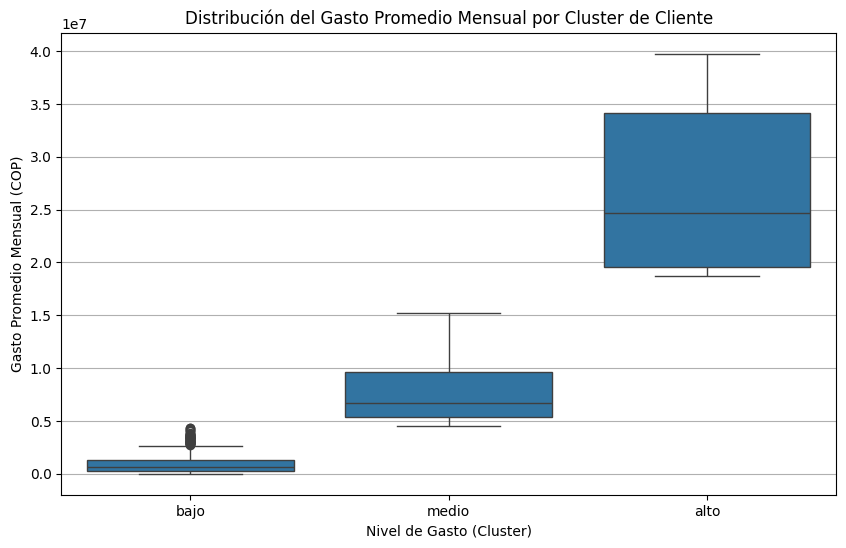

In [15]:
# Visualización de los clusters en boxplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_gasto', y='prom_gasto_mensual', data=resumen_filtrado)
plt.title("Distribución del Gasto Promedio Mensual por Cluster de Cliente")
plt.xlabel("Nivel de Gasto (Cluster)")
plt.ylabel("Gasto Promedio Mensual (COP)")
plt.grid(axis='y')
plt.show()


In [16]:
#Exportacion del archivo en excel asociado con el nivel de gasto de los clientes basado en las categorias asignadas de los clusters }
# 1. Agregar la columna nivel_gasto a todo el resumen
resumen = resumen.merge(
    resumen_filtrado[['cod_cliente', 'nivel_gasto']],
    on='cod_cliente',
    how='left'
)

# 2. Llenar valores vacíos como 'no_clasificado'
resumen['nivel_gasto'] = resumen['nivel_gasto'].fillna('no_clasificado')

# 3. Calcular prom_gasto_anual
resumen['prom_gasto_anual'] = resumen['prom_gasto_mensual'] * 12

# 4. Seleccionar columnas a exportar
columnas_exportar = [
    'cod_cliente', 'cliente', 
    'prom_cantidad_mensual', 'prom_gasto_mensual', 'prom_gasto_anual', 
    'nivel_gasto'
]

# 5. Exportar a Excel
resumen[columnas_exportar].to_excel("./outputs/clientes_segmentados_con_clusters.xlsx", index=False)


In [40]:
resumen = resumen.merge(
    resumen_filtrado[['cod_cliente', 'nivel_gasto']],
    on='cod_cliente',
    how='left'
)


In [41]:
# Llenar los valores no asignados con 'no_clasificado'
resumen['nivel_gasto'] = resumen['nivel_gasto'].fillna('no_clasificado')


In [42]:
# Asignar comentario estratégico
def clasificar_cliente(row):
    if row['nivel_gasto'] == 'alto' and row['es_b2b_probable']:
        return '🟢 Cliente ideal B2B'
    elif row['nivel_gasto'] == 'medio':
        return '🟡 Cliente potencial a desarrollar'
    elif row['nivel_gasto'] == 'bajo':
        return '🔘 Cliente pequeño o marginal'
    elif row['nivel_gasto'] == 'no_clasificado':
        return '🔴 Cliente con datos negativos o inconsistentes'
    else:
        return 'Sin clasificación'

resumen['comentario_estrategico'] = resumen.apply(clasificar_cliente, axis=1)


In [43]:
resumen['prom_gasto_anual'] = resumen['prom_gasto_mensual'] * 12


In [44]:
columnas_exportar = [
    'cod_cliente', 'cliente',
    'meses_con_compra', 'prom_cantidad_mensual',
    'prom_gasto_mensual', 'prom_gasto_anual',
    'nivel_gasto', 'es_nombre_empresa', 'es_b2b_probable', 'comentario_estrategico'  
]

resumen[columnas_exportar].to_excel("../outputs/clientes_segmentados_final.xlsx", index=False)


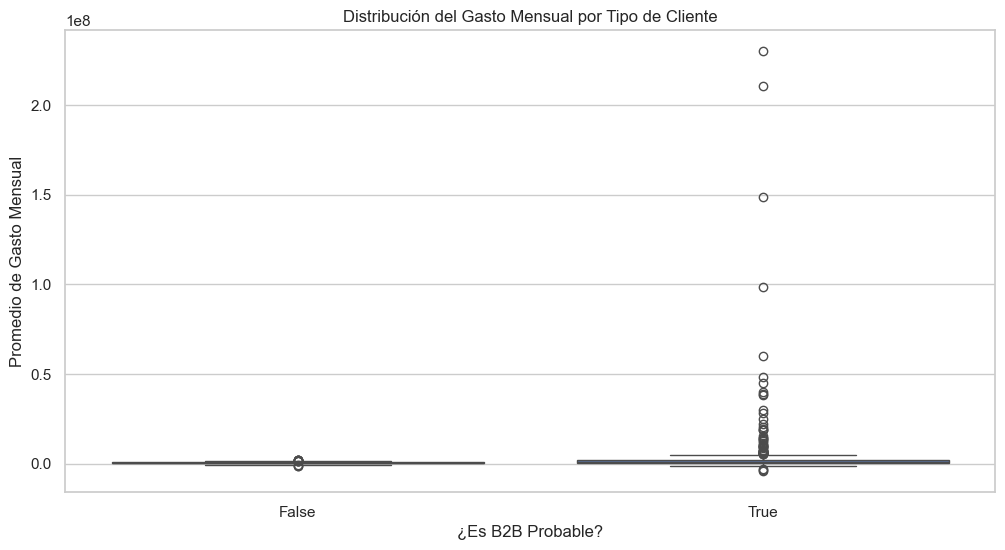

In [15]:
#Visualizacion de clientes probables y clientes no probables 
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración general
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Distribución de gasto mensual por tipo de cliente
sns.boxplot(data=resumen, x='es_b2b_probable', y='prom_gasto_mensual')
plt.title('Distribución del Gasto Mensual por Tipo de Cliente')
plt.xlabel('¿Es B2B Probable?')
plt.ylabel('Promedio de Gasto Mensual')
plt.show()


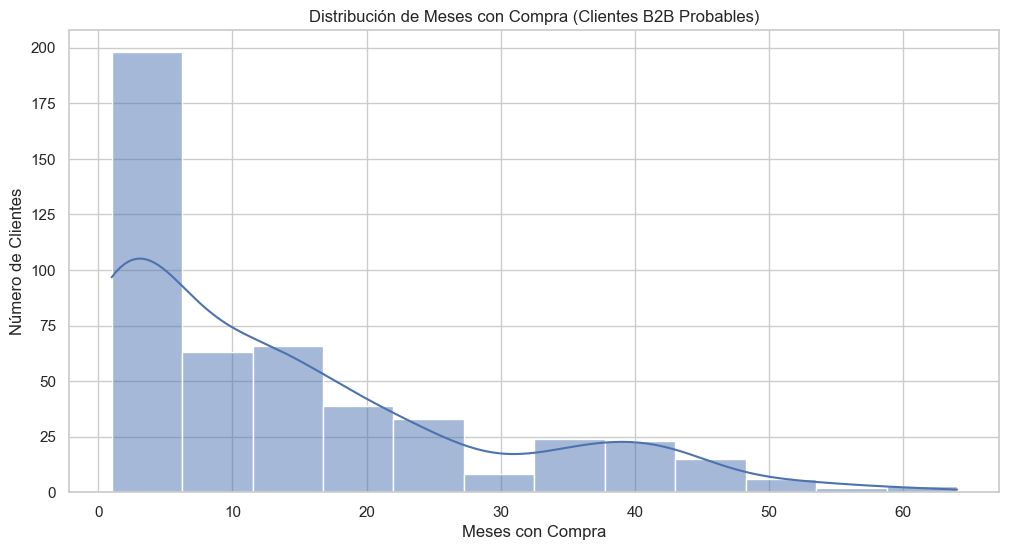

In [16]:
#Clientes Clasificados como B2B : Numero de meses con compra
plt.figure(figsize=(12, 6))
sns.histplot(data=resumen[resumen['es_b2b_probable']], x='meses_con_compra', bins=12, kde=True)
plt.title('Distribución de Meses con Compra (Clientes B2B Probables)')
plt.xlabel('Meses con Compra')
plt.ylabel('Número de Clientes')
plt.show()


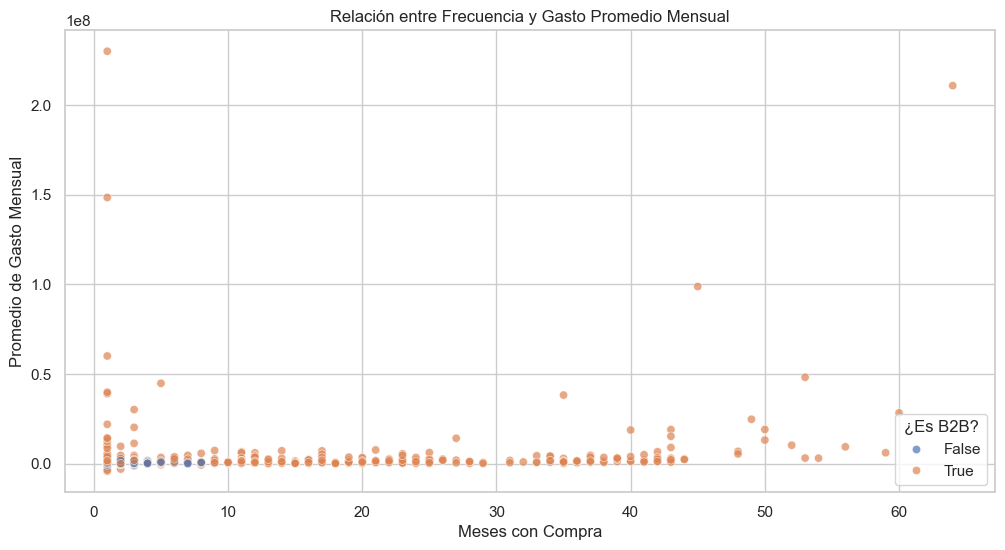

In [17]:
#Relacion entre gaso y frecuencia de clientes
plt.figure(figsize=(12, 6))
sns.scatterplot(data=resumen, x='meses_con_compra', y='prom_gasto_mensual', hue='es_b2b_probable', alpha=0.7)
plt.title('Relación entre Frecuencia y Gasto Promedio Mensual')
plt.xlabel('Meses con Compra')
plt.ylabel('Promedio de Gasto Mensual')
plt.legend(title='¿Es B2B?')
plt.show()


Revision estructural de los clientes

Antes de ejecutar cualquier análisis, es esencial entender la estructura del archivo. Esto incluye:

1. Las **columnas** que contiene el dataset.
2. Los **tipos de datos** asociados a cada una, lo cual impacta directamente en el procesamiento y análisis posterior.


In [10]:
#Identificacion de las columnas del archivo 
print("📌 Columnas del archivo (formato vertical):")
for col in df.columns:
    print(f"• {col}")


📌 Columnas del archivo (formato vertical):
• codigo
• razon social
• direccion
• nombre ciudad
• cod ciudad
• cupo
• plazo
• telefonos
• contactos
• telefonos.1
• telefonos.2
• email
• vendedor
• nit
• dv
• distrito
• pais


In [9]:
#Tipos de datos asociados en el archivo de clientes 
print("🧠 Tipos de datos:")
print(df.dtypes)


🧠 Tipos de datos:
codigo           object
razon social     object
direccion        object
nombre ciudad    object
cod ciudad        int64
cupo              int64
plazo             int64
telefonos        object
contactos        object
telefonos.1      object
telefonos.2      object
email            object
vendedor         object
nit              object
dv                int64
distrito         object
pais             object
dtype: object


In [11]:
#Primeras filas asociadas al archivo de clientes
print("🔍 Primeras filas:")
df.head()


🔍 Primeras filas:


,codigo,razon social,direccion,nombre ciudad,cod ciudad,cupo,plazo,telefonos,contactos,telefonos.1,telefonos.2,email,vendedor,nit,dv,distrito,pais
0,CL 200000000200,100NUTRITION SAS,CALLE 95 # 11A -84 OFICINA 403,BOGOTA - D.C.,11001,0,0,NaN,NaN,3162357062,NaN,MANAGER@CIENUTRITION.ORG,NaN,900967772,2,NaN,CO - COLOMBIA
1,CL 400000000784,ACIE SAS,CR 7 126 30,BOGOTA D. C.,11001,0,0,NaN,NaN,3008003308,NaN,ELGASANCHEZ@GMAIL.COM,NaN,900421292,5,NaN,CO - COLOMBIA
2,CL 400000000305,ADMINISTRADORA MONSERRAT,CR 2 ESTE 21 48,BOGOTA D. C.,11001,0,0,11111111,NaN,3108847077,NaN,NaN,NaN,800124979-1,6,NaN,CO - COLOMBIA
3,CL 200000000319,ALMINISTRADORA MONSERRATE,CARRERA 2 ESTE 21 48,BOGOTA D. C.,11001,0,0,1111111,NaN,3208031265,NaN,DIRECCIONADMINISTRATIVA@RESTAURANTESMONSERRATE...,NaN,800124979,1,NaN,CO - COLOMBIA
4,CL 400000000508,AUDIASESORES,XX,BOGOTA D. C.,11001,0,0,XX,NaN,XX,NaN,NaN,NaN,800211129-9,5,NaN,CO - COLOMBIA


In [12]:
#Valores nulos asociados por columna
print("⚠️ Valores nulos por columna:")
print(df.isnull().sum())


⚠️ Valores nulos por columna:
codigo              0
razon social        0
direccion         253
nombre ciudad       0
cod ciudad          0
cupo                0
plazo               0
telefonos        2362
contactos        6793
telefonos.1      2102
telefonos.2      7482
email            2304
vendedor         5859
nit                 8
dv                  0
distrito         6184
pais              284
dtype: int64


In [13]:
#Porcentaje de nulos asociados al archivo de clientes
print("📉 Porcentaje de nulos por columna:")
print((df.isnull().mean() * 100).round(2))


📉 Porcentaje de nulos por columna:
codigo            0.00
razon social      0.00
direccion         3.20
nombre ciudad     0.00
cod ciudad        0.00
cupo              0.00
plazo             0.00
telefonos        29.86
contactos        85.89
telefonos.1      26.58
telefonos.2      94.60
email            29.13
vendedor         74.08
nit               0.10
dv                0.00
distrito         78.19
pais              3.59
dtype: float64


In [14]:
#Filas dupicadas en el archivo de clientes
print("🧬 Filas duplicadas:")
print(df.duplicated().sum())


🧬 Filas duplicadas:
0


In [15]:
#Cardinalidad de las columnas aplicadas en el archivo de clientes
print("🔢 Cardinalidad (valores únicos) por columna:")
print(df.nunique())


🔢 Cardinalidad (valores únicos) por columna:
codigo           7909
razon social     7801
direccion        6691
nombre ciudad     125
cod ciudad        124
cupo               21
plazo              10
telefonos        5039
contactos         916
telefonos.1      5441
telefonos.2       233
email            5318
vendedor           17
nit              7446
dv                 10
distrito            5
pais                3
dtype: int64


Con el fin de entender mejor la distribución de los valores numéricos en el archivo de clientes, se ejecutó un análisis estadístico básico sobre las siguientes variables:

- `cod ciudad`
- `cupo`
- `plazo`
- `dv`

---Este resumen estadístico permite identificar outliers, inconsistencias o nulos relevantes que deben ser tenidos en cuenta en procesos de limpieza o validación antes de cualquier modelado avanzado o segmentación de clientes.

In [16]:
#Estadisticas descriptivas del archivo de clientes asociadas a las columnas numericas
print("📊 Estadísticas de columnas numéricas:")
df.describe()


📊 Estadísticas de columnas numéricas:


,cod ciudad,cupo,plazo,dv
count,7909.000000,7.909000e+03,7909.000000,7909.000000
mean,14529.334556,1.055633e+05,1.786319,3.106208
std,13773.335673,1.619304e+06,6.775231,3.147302
min,5001.000000,0.000000e+00,0.000000,0.000000
25%,11001.000000,0.000000e+00,0.000000,0.000000
50%,11001.000000,0.000000e+00,0.000000,2.000000
75%,11001.000000,0.000000e+00,0.000000,6.000000
max,99991.000000,1.000000e+08,60.000000,9.000000



Este análisis explora las variables categóricas del archivo de clientes, mostrando los 10 valores más frecuentes para cada una. Es útil para identificar duplicidades, valores dominantes y posibles problemas de calidad de datos.

---

1. Se seleccionan todas las columnas categóricas (`dtype = object`) del dataframe.
2. Para cada columna categórica, se calcula el `value_counts()` y se muestran los 10 valores más frecuentes.
3. Esto permite visualizar:
   - Si hay clientes repetidos (`codigo`)
   - Si hay razones sociales duplicadas o mal registradas
   - La diversidad de países y su frecuencia



- **Código del cliente**: Todos los valores del top 10 aparecen una sola vez, lo cual es esperable si cada cliente tiene un identificador único.
- **Razón social**: Algunas razones sociales como `PEREA PEREZ MARIA ANGELICA`, `GROW DATA SAS` o `CORPORACION CLUB PAYANDE` aparecen tres veces, lo que puede sugerir:
  - Clientes registrados múltiples veces (posible duplicidad).
  - Diferentes puntos de venta o sucursales que comparten razón social.

- **País**: Claramente dominado por `CO – COLOMBIA` con más de 7.600 registros, seguido muy de lejos por otros países como `PORTUGAL` o `AFGANISTAN` con apenas 1 ocurrencia cada uno.

---


- Ayuda a detectar registros duplicados o inconsistencias en campos clave.
- Da contexto sobre la concentración geográfica de los clientes.
- Permite enfocar procesos de limpieza o estandarización de datos.

Este análisis es clave antes de realizar segmentaciones, análisis de rotación o atribución de patrones de compra, asegurando que los valores categóricos estén limpios y correctamente estructurados.


In [17]:
#Frecuencia de valores categoricos 
columnas_categoricas = df.select_dtypes(include='object').columns

print("📈 Frecuencia de valores categóricos (top 10):")
for col in columnas_categoricas:
    print(f"\n🔸 {col} (top 10):")
    print(df[col].value_counts().head(10))


📈 Frecuencia de valores categóricos (top 10):

🔸 codigo (top 10):
codigo
CL  200000000200    1
CL 5200000001042    1
CL 5200000001343    1
CL  200000000173    1
CL 5200000000580    1
CL  200000000137    1
CL  400000000391    1
CL  200000000264    1
CL  400000000282    1
CL  400000002587    1
Name: count, dtype: int64

🔸 razon social (top 10):
razon social
PEREA PEREZ MARIA ANGELICA                        3
GROW DATA SAS                                     3
CORPORACION CLUB PAYANDE                          3
LABORATORIO FRANCO COLOMBIANO LAFRANCOL S.A.S.    3
MAGNUS SEGURIDAD LTDA                             2
SELIOS SAS                                        2
DONADO GARZON MAURICIO ANDRES                     2
DALIMENTOS SAS                                    2
INVERSIONES TOMATE SAS                            2
SISTEMAS Y SOLUCIONES ATHENEA S.A.S               2
Name: count, dtype: int64

🔸 direccion (top 10):
direccion
...          156
---          100
----          86
....        

Analisis Avanzado de clientes premium:; 
Identificacion y presentacion de clientes especializado para identificar el comportamiento de los clientes de alto valor.

In [1]:
# Ver valores de los centroides
for i, centroide in enumerate(centroides):
    print(f"Cluster {i} ({cluster_map[i]}): promedio de gasto mensual = {centroide:,.0f}")

# También en DataFrame para exportar si se quiere
import pandas as pd
df_centroides = pd.DataFrame({
    'Cluster': ['Bajo', 'Medio', 'Alto'],
    'Promedio_gasto_mensual': sorted(centroides)
})

df_centroides['Promedio_gasto_anual'] = df_centroides['Promedio_gasto_mensual'] * 12

df_centroides.to_excel("./outputs/centroides_kmeans_clientes.xlsx", index=False)
df_centroides


NameError: name 'centroides' is not defined

In [ ]:
#Frecuencia de Compra
#Detectar clientes recurrentes vs. transaccionales ocasionales.

In [ ]:
#Categorias mas compradas por cliente premium 
#Entender qué líneas de producto prefieren los mejores clientes.

In [ ]:
#Segmentacion de Clientes por nivel de valor 
#Generar etiquetas o segmentos para identificar a la “inmensa minoría”.